# Solving systems of linear equations

## Contents
+ Detecting collisions in a 2D video game
+ Writing equations to represent lines and finding where lines intersect in the plane
+ Picturing and solving systems of linear equations in 3D or beyond
+ Re-writing vectors as linear combinations of other vectors

## Intro

This chapter deals with *systems of linear equations*. These problems boild down to finding points where lines, planes, or their higher dimensional analogies intersect.

To make things interesting, we'll develop an [Asteroids](https://en.wikipedia.org/wiki/Asteroids_(video_game)) bootleg in which we'll need to deal with these equations to figure out when the laser hits an asteroid.

Afterwards, we'll generalize the approach to higher dimensions.

## Designing the game

As we'll use the game as the *playground* to understand where equations are useful, we will simplify the approach and assume that the ship and asteroids are static for now.

### Modeling the game
To get started, we must model the entities of the game: the spaceship, the laser, and the asteroids. We also need to lay out the strategy to render them onscreen.

The spaceship and asteroids will be modeled as collections of vectors. For example, the following diagram is an 8-sided asteroid, defined by eight vectors.

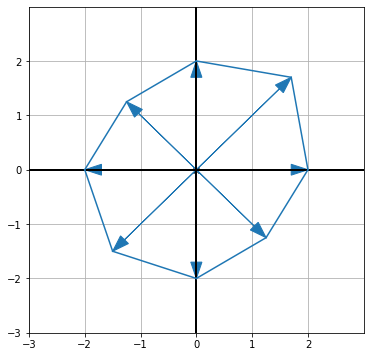

In [12]:
from my_draw2d import Arrow2D, Polygon2D, draw2d, blue

points = [(0, 2), (1.7, 1.7), (2, 0), (1.25, -1.25), (0, -2),
            (-1.5, -1.5), (-2, 0), (-1.25, 1.25)]

arrows = [Arrow2D(p, color=blue) for p in points]
polygon = Polygon2D(*points, color=blue)

draw2d(*arrows, polygon)

Both the asteroid and the spaceship will be subject of translations and rotations, which hints that apart from storing the eight vectors that define it, we need to keep track of its center, which will change over time, and the angle indicating the rotation of the object at any current moment.

As both the spaceship and the asteroids will share some *traits* it seems natural to pull these commonalities into a class that will define both:

In [ ]:
class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

Now we can start defining the ship as a subclass of `PolygonModel` as a triangle with fixed measurements:

In [13]:
class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

class Ship(PolygonModel):
    def __init__(self):
        super().__init__([(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)])

For the asteroid, we initialize it with a random number of points between 5 and 9, at equally spaced angles and random lengths between 0.5 and 1.0.as_integer_ratio.

In [15]:
from my_vectors import to_cartesian
from math import pi
from random import randint, uniform

class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

class Asteroid(PolygonModel):
    def __init__(self):
        sides = randint(5, 9)
        points = [to_cartesian((uniform(0.5, 1.0), 2 * pi * i / sides))
            for i in range(0, sides)
        ]
        super().__init__(points)

### Rendering the game

For the initial state of the game, we need a ship and several asteroids. We'll place the ship at the center of the screen, with the asteroids randomly spaced out over the screen. We'll show everything in the area of the plane ranging from -10 to 10 in the x and y directions.

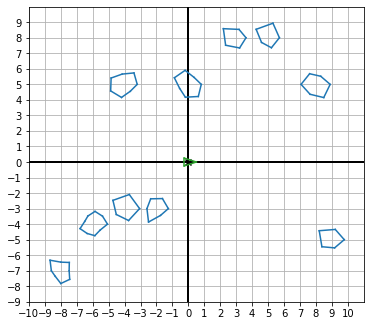

In [1]:
from my_game import Ship, Asteroid
from random import randint
from my_draw2d import Arrow2D, Polygon2D, draw2d, blue, green

asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

translated_asteroid_points = [
    [(x + asteroid.x, y + asteroid.y) for (x, y) in asteroid.points] for asteroid in asteroids
]

asteroids_as_polygons = [Polygon2D(*asteroid_points, color=blue) for asteroid_points in translated_asteroid_points]

ship = Ship()

draw2d(*asteroids_as_polygons, Polygon2D(*ship.points, color=green))

We can define a function in `PolygonModel` to represent this transformation:

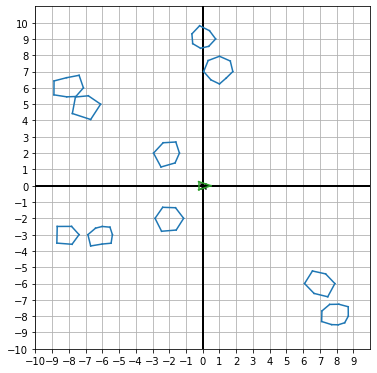

In [9]:
from my_vectors import add, to_cartesian
from my_game import Ship
from random import randint, uniform
from my_draw2d import Arrow2D, Polygon2D, draw2d, blue, green
from math import pi

class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

    def transformed(self):
        return [add((self.x, self.y), v) for v in self.points]

class Asteroid(PolygonModel):
    def __init__(self):
        sides = randint(5, 9)
        points = [to_cartesian((uniform(0.5, 1.0), 2 * pi * i / sides))
            for i in range(0, sides)
        ]
        super().__init__(points)

asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

ship = Ship()

draw2d(*[Polygon2D(*asteroid.transformed()) for asteroid in asteroids], Polygon2D(*ship.points, color=green))

We will be using a 400x400 pixel screen, and the coordinate convention for computer displays, which is slightly different than the one used for math plots:

![Math to Computer displays](../images/math-to-computer-coordinates.png)

To facilitate the *translation* from the math axis coordinates to the ones used for computer games, we can write a `to_pixels()` function:

In [10]:
width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

# (0, 0) gets mapped to the center of the game window
print(to_pixels(0, 0)) 

# the right top corner gets mapped to the right top corner of the game window
print(to_pixels(10, 10))

# the right bottom corner gets mapped to the right bottom corner of the game window
print(to_pixels(10, -10))

# the left top corner gets mapped to the left top corner of the game window
print(to_pixels(-10, 10))

# the left bottom corner gets mapped to the left bottom corner of the game window
print(to_pixels(-10, -10))

(200.0, 200.0)
(400.0, 0.0)
(400.0, 400.0)
(0.0, 0.0)
(0.0, 400.0)


Now we can write the first step of the game, which just consists of the asteroids and ship being displayed using the `pygame` engine with no movement.

You can also find the runnable code in [Asteroids: first step](../e00-my-draw-lib+game-entities/asteroids_step1.py)

In [2]:
import pygame
from my_game import Ship, Asteroid
from random import randint
import sys

# Initialize game state
ship = Ship()
asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

# colors and settings

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points, 10)


def main():
    pygame.display.init()
    screen = pygame.display.set_mode([width, height])
    pygame.display.set_caption('Asteroids')

    done = False
    clock = pygame.time.Clock()

    while not done:
        clock.tick()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True

        screen.fill(BLACK)

        draw_poly(screen, ship)
        for asteroid in asteroids:
            draw_poly(screen, asteroid, color=GREEN)
        
        pygame.display.flip()

    pygame.display.quit()
    pygame.quit()
    sys.exit(0)

if __name__ == '__main__':
    main()

SystemExit: 0

### Shooting the laser

Now, we'll add the capability to let the user aim the ship using the left and right arrow keys, and then shoot a laser by pressing the spacebar.

As in the original Asteroids game, the laser beam should come out of the tip of the spaceship and extend to the edge of the screen.

In our 2D world model, the laser beam will be a segment starting at the transformed top of the spaceship, extending in whatever direction the ship is pointed. We will make sure it reaches the end of the screen by making it sufficiently long.

We'll add a method `laser_segment(...)` in the `Ship` class, as part of our [Asteroids: second step](../e00-my-draw-lib+game-entities/asteroids_step2.py)

```python
    def laser_segment(self):
        dist = 20 * sqrt(2)
        x, y = self.transformed()[0]
        return ((x,y), (x + dist * cos(self.rotation_angle), y + dist * sin(self.rotation_angle)))
```

The `laser_segment(...)` uses what we know about trigonometry to find a point that is guaranteed to be off-screen.

![Laser beam trigonometry](../images/laser_beam_trigonometry.png)

From the chapter in which we defined the $ sin(\theta) $ and $ cos(\theta) $, we know that for a right triangle of sides x and y:

![Basics of trigonometry](../../01-vectors-in-the-2d-plane/images/sin_cos_tan.png)


Note that we set the distance of the of the laser to be $ 20 \sqrt{2} $. As we then use our `to_pixels()` that is enough to make the laser end off-screen.

The math for that $ 20 \sqrt{2} $ lies in the fact that our model for the polygons is based on an x-y traditional coordinate plane that goes from -10 to 10. Therefore, the max distance between two any given points would be $ 20 \sqrt{2} $, as per the Pythagoras theorem.

In [3]:
from math import sqrt

width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

to_pixels(20 * sqrt(2), 0)

(765.685424949238, 200.0)

Now we need to add the code to handle the user interaction, so that the user can shoot the laser. We'll then implement in a subsequent step how to check if the laser hits an asteroid, and how to rotate and move the ship:

In [2]:
import pygame
from my_game import Ship, Asteroid
from random import randint
import sys

# Initialize game state
ship = Ship()
asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

# colors and settings

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points, 10)

# added in section 7.1.6
def draw_segment(screen, v1, v2, color=RED):
    pygame.draw.aaline(screen, color, to_pixels(*v1), to_pixels(*v2), 10)

def main():
    pygame.display.init()
    screen = pygame.display.set_mode([width, height])
    pygame.display.set_caption('Asteroids')

    done = False
    clock = pygame.time.Clock()

    while not done:
        clock.tick()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True

        # added in section 7.1.6
        laser = ship.laser_segment()            

        screen.fill(BLACK)
        
        keys = pygame.key.get_pressed()
        if keys[pygame.K_SPACE]:
            draw_segment(screen, *laser)

        draw_poly(screen, ship)
        for asteroid in asteroids:
            draw_poly(screen, asteroid, color=GREEN)
        
        pygame.display.flip()

    pygame.display.quit()
    pygame.quit()
    sys.exit(0)

if __name__ == '__main__':
    main()

SystemExit: 0

You can find the debuggable project in [Asteroids: second step](../e00-my-draw-lib+game-entities/asteroids_step2.py).

## Finding intersection points of lines

The next step for finalizing the game is to decide whether the laser beam hits the asteroid. The Mathematical problem at hand is to identify if the segment defining the laser beam intersects with the line segments defining the asteroid.

This will be solved by a system of linear equations in two variables.

The following picture describes what we want to achieve, and what are the Mathematical elements involved:

![Finding intersection points](../images/intersection_game_and_math_model.png)

The approach will be as follows:
+ Locate the intersection point
+ Identify whether it lies within the bounds of both segments
+ How to repeat the process to find all points where there is intersection
+ Generalize in the game creating a `does_intersect(...)` function.

### Choosing the right formula for a line

We saw in the previous chapter that 1D subspaces of the 2D planes are lines consisting of all the scalar multiple $t \cdot v $ for a single chosen vector $ v $. We also saw that in order to be a proper subspace, that lines always pass through the origin $ (0, 0) $. This means that the $ t \cdot v $ formula is not general enough to describe any line we might encounter &mdash; we need to translate it by another vector.

Therefore, to get any possible line we can use: $ u + t \cdot v $.

For example:
+ Let $ v = (2, -1) $. The points on the line go through the origin 
+ Let $ u = (2, 3) $. The points in $ (2, 3) + t \cdot (2, -1) $ constitute a line that does not pass through the origin.

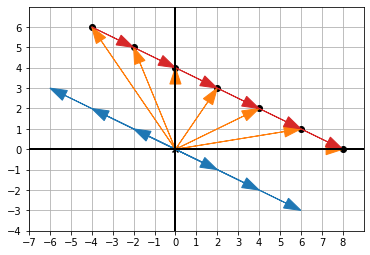

In [18]:
from my_draw2d import draw2d, Arrow2D, Points2D
from my_colors import blue, orange, black
from my_vectors import scale, add

v = (2, -1)

vs = [Arrow2D(scale(t, v), color=blue) for t in range(-3,4)]

u = (2, 3)
ws = [Arrow2D(add(u, scale(t, v)), color=orange) for t in range(-3, 4)]
ws_points = [add(u, scale(t, v)) for t in range(-3, 4)]
ws_line_vectors = [Arrow2D(ws_points[i + 1], ws_points[i]) for i in range(0, len(ws_points) - 1)]

draw2d(*vs, *ws, Points2D(*ws_points, color=black), *ws_line_vectors)

Any line can be described as the points $ u + t \cdot v $ for some selection of vectors $ u $ and $ v $, and all possible scalar multiples $ t $.

Many times, the line is written as:

$
r(t) = u + t \cdot v
$

to indicate that the line is a vector valued function of the scalar parameter $ t $.

The advantage of using this definition for the line is that it simplifies the identification of any two points on the line.

If you have two points $ u $ and $ w $ you can use $ u $ as the translation vector and $ w - u $ as the $ v $, the vector that gets scaled.

Let's see it graphically to understand what we mean:

Let $ u = (2, 3) $ and $ w = (4, 2) $ two points, for which I want to find the line that connects them.

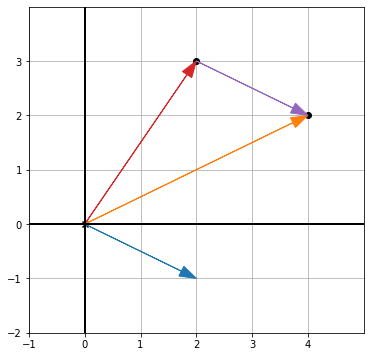

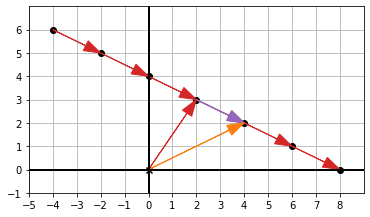

In [31]:
from my_draw2d import draw2d, Arrow2D, Points2D
from my_colors import blue, orange, black, red, purple
from my_vectors import scale, add, subtract

u = (2, 3)
w = (4, 2)

translation_vector = subtract(w, u)

draw2d(
    Points2D(u, w),
    Arrow2D(u, color=red), Arrow2D(w, color=orange),
    Arrow2D(translation_vector, color=blue),
    Arrow2D(w, u, color=purple)
    )

def r(t):
    return add(u, scale(t, subtract(w, u)))

line_points = [r(t) for t in range(-3, 4)]
line_vectors = [Arrow2D(line_points[i + 1], line_points[i]) for i in range(0, len(line_points) - 1)]

draw2d(
    Points2D(*line_points),
    *line_vectors,
    Arrow2D(w, u, color=purple),
    Arrow2D(u, color=red), Arrow2D(w, color=orange)
)


As a summary, we can easily write the line connecting two points identified by the vectors $ w $ and $ u $ using the formular

$
r(t) = u + (w - u) \cdot t
$

Note that the formulat also has some downsides, as there are multiple ways to write the same line in this form. Also, the extra parameter $ t $ makes it harder to solve equations because there is one extra unknown variable.

However, it is more flexible than the formula $ y = m \cdot x + n $, because the former cannot be used to describe a vertical line (e.g. the one that spans using x = 3), while our $ r(t) $ formula can do that as demonstrated below.

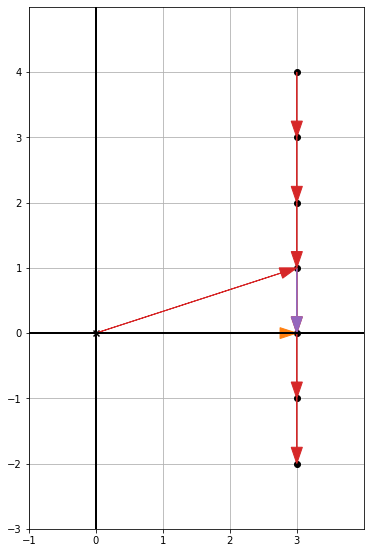

In [32]:
from my_draw2d import draw2d, Arrow2D, Points2D
from my_colors import blue, orange, black, red, purple
from my_vectors import scale, add, subtract

u = (3, 1)
w = (3, 0)

def r(t):
    return add(u, scale(t, subtract(w, u)))

line_points = [r(t) for t in range(-3, 4)]
line_vectors = [Arrow2D(line_points[i + 1], line_points[i]) for i in range(0, len(line_points) - 1)]

draw2d(
    Points2D(*line_points),
    *line_vectors,
    Arrow2D(w, u, color=purple),
    Arrow2D(u, color=red), Arrow2D(w, color=orange)
)


It would be great to have a formula that combines the strong points of the *parametric* ($ r(t) = u + (w- u)\cdot t $) and *classic* ($ y = m \cdot x + n $):
+ any line can be described by the formula, even vertical ones
+ it does not have any extra parameters

Let's consider the following formula:

$
a \cdot x + b \cdot y = c
$

That formula can be used to describe any line.

For example, the line connecting the points $ (2, 4) $ and $ (4, 2) $ can be described in this form as:

$
x + 2 \cdot y = 8
$

All the points satisfying the equation above gives us the line that connects $ (2, 4) $ and $ (4, 2) $.

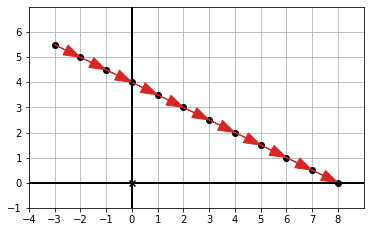

In [37]:
from my_draw2d import draw2d, Arrow2D, Points2D
from my_colors import blue, orange, black, red, purple
from my_vectors import scale, add, subtract

u = (2, 4)
w = (4, 2)

points = [(x, (8 - x) / 2 ) for x in range(-3, 9)]
vectors_in_the_line = [Arrow2D(points[i + 1], points[i]) for i in range(0, len(points) - 1)]

draw2d(
    Points2D(*points, color=black),
    *vectors_in_the_line
)

The form $ ax + by = c $ has no extra parameters and can represent any line.

Any equation representing a line is called a *linear equation* and this in particular is called the *standard form* for a linear equation. This is the preferred way to represent the line for our problem at hand.

### Finding the standard form equation for a line

Consider the following asteroid, expressed in our *Math model* coordinates.

![Asteroid Border](../images/asteroid-border-equation.png)



The standard form for the linear equation for those two points is:

$
ax + by = c \\
x = 1 \Rightarrow y = 5 \\
x = 2 \Rightarrow y = 3
$

Another more formal way to solve it is to go back to our *parametric* formula:

Let $ u = (1, 5) $, $ w = (2, 3) $, then the parametric formula that gives us the line connecting those points will be:

$
r(t) = (1, 5) + ((2, 3) - (1, 5) \cdot t)
$
for some $ t $

We can rewrite the previous formula using the Cartesian coordinates $ (x,y) $ which will give us a pair of equations with 3 parameters:

$
(x, y) = (1, 5) + ((2, 3) - (1, 5) \cdot t) \Rightarrow \\
(x, y) = (1, 5) + (1, -2) \cdot t \Rightarrow \\
\\
\begin{cases}
x = 1 + t \\
y = 5 - 2t
\end{cases}
$

Now, we need to do get rid of $ t $, which we can do by clearing that parameter in both equations, so that we can equalize them:

$
\begin{cases}
x = 1 + t \Rightarrow 2x = 2 + 2t \Rightarrow 2t = 2x - 2 \\
y = 5 - 2t \Rightarrow 2t = 5 - y
\end{cases} \Rightarrow 2x -2 = 5 - y \Rightarrow \\
2x + y = 7
$

Therefore, the *standard form* for the line connecting $ (1, 5) $ and $(2, 3) $ is $ 2x + y = 7 $.

Now, that we know how to find the *standard form* for a concrete case, we need to generalize it for a couple of $ (x_1, y_1) $ and $ (x_2, y_2) $ points.

$ 
u = (x_1, y_1) \\
w = (x_2, y_2)
$

$
r(t) = (x, y) = (x_1, y_1) + ((x_2, y_2) - (x_1, y_1)) \cdot t = (x_1, y_1) + (x_2 - x_1, y_2 - y_1) \cdot t \Rightarrow \\
\begin{cases}
x = x_1 + (x_2 - x_1) \cdot t \\
y = y_1 + (y_2 - y_1) \cdot t
\end{cases}
$



Now, we need to get rid of the extra parameter $ t $. We can do it by *clearing out* $ t $ in one of the equations, and then substituting it in the other:

$
t = \frac{x - x_1}{x_2 - x_1} \Rightarrow \\
y = y_1 + (y_2 - y_1) \cdot \frac{x - x_1}{x_2 - x_1} \Rightarrow \\
(x_2 - x_1)y = (x_2 - x_1)y_1 + (y_2 - y_1)(x - x_1) 
$


The next step consists in assimilating the previous formula to the format of the *standard form*: $ ax + by = c $

$
(y_2 - y_1)x - (x_2 - x_1)y = x_1(y_2 - y_1) - (x_2 - x_1)y_1 \Rightarrow \\
(y_2 - y_1) \cdot x + (x_1 - x_2) \cdot y = x_1 (y_2 - y_1) + (x_1 - x_2) y_1
$

We can check we get the expected results for:

$
(x_1, y_1) = (1, 5) \\
(x_2, y_2) = (2, 3)
$

$
-2x - y = -2 -5 \Rightarrow 2x + y = 7
$


We can use the formula again for getting the line defined by the laser when the ship is rotated $ \frac{\pi}{4} $

![Laser beam line](../images/laser_beam_line.png)

The line will pass through $ (2, 2) $ and $ (4, 4) $. Therefore, using the formula we get:

$
(x_1, y_1) = (2, 2) \\
(x_2, y_2) = (4, 4) \\
(y_2 - y_1) \cdot x + (x_1 - x_2) \cdot y = x_1 (y_2 - y_1) + (x_1 - x_2) y_1 \Rightarrow \\
2x - 2y = 2 \cdot 2 + (-2) \cdot 2 \Rightarrow \\
x - y = 0
$

Thus, the line is $ y = x $.

Now, we need to find where the line $ x - y = 0 $ intersects with $ 2 x + y = 7 $.


### Linear equations in matrix notation

Let's suppose we have an asteroid whose edge is defined by the line $ x + 2y = 8 $, and we are wondering whether the laser beam defined by the line $ x - y = 0 $ intersects.

Visually:

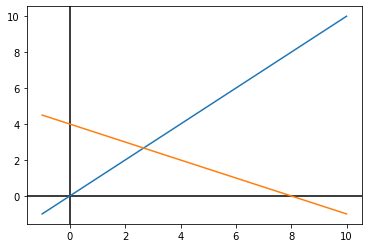

In [1]:
from my_plot import plot

def beam(x):
    return x

def asteroid_edge(x):
    return (8 - x) / 2



plot([beam, asteroid_edge], -1, 10)

So, we know there'll be a colision in the intersection between the blue line that defines the laser beam, and the asteroid edge defined by the orange line.

Finding the intersection is finding the solution for the following system of linear equations:

$
x - y = 0 \\
x + 2y = 8
$

Those equations can be rewritten as a single matrix equation:

$
x \begin{pmatrix}
1 \\
1
\end{pmatrix} + y \begin{pmatrix}
-1 \\
2
\end{pmatrix} = \begin{pmatrix}
0 \\
8
\end{pmatrix}
$

And we can even write it in a more compact way as:

$
\begin{pmatrix}
1 & -1 \\
1 & 2
\end{pmatrix} \begin{pmatrix}
x \\
y
\end{pmatrix} = \begin{pmatrix}
0 \\
8
\end{pmatrix}
$

When written in this way, finding the solution of the system of linear equations become finding the vector $ (x, y) $ that when applied to the linear transformation defined by the $ 2x2 $ matrix yields $ (0, 8) $.

### Solving linear equations with NumPy

So, we have established that finding the intersection of $ x - y = 0 $ and $ x + 2y = 8 $ is the same as finding the vector $ (x, y) $ that satisfies the matrix multiplication equation:

$
\begin{pmatrix}
1 & -1 \\
1 & 2
\end{pmatrix} \begin{pmatrix}
x \\
y
\end{pmatrix} = \begin{pmatrix}
0 \\
8
\end{pmatrix}
$

Writing the problem in this way let us use pre-built tools to solve it, like *NumPy* library:

In [3]:
import numpy as np

matrix = np.array(((1, -1), (1, 2)))
output = np.array((0, 8))

solution = np.linalg.solve(matrix, output)

print(solution)


[2.66666667 2.66666667]


That is, using *NumPy* has told us that the intersection falls in $ \frac{8}{3} $ or $ 2^{\frac{2}{3}} $.

If we plug those values into the equations, we see that it gives us the expected values:

$
\text{for: } x - y = 0 \Rightarrow \frac{8}{3} - \frac{8}{3} = 0 \\
\text{for: } x + 2y = 8 \Rightarrow \frac{8}{3} + 2 \cdot \frac{8}{3} = 8 \\
$

And therefore:

$
\begin{pmatrix}
1 & -1 \\
1 & 2
\end{pmatrix} \begin{pmatrix}
\frac{8}{3} \\
\frac{8}{3}
\end{pmatrix} = \begin{pmatrix}
0 \\
8
\end{pmatrix}
$

We can think of NumPy's `linalg.solve(...)` as a transformation that takes a known matrix and an output vector and returns the *solution* vector, and we will use this function to decide whether the laser hits an asteroid.

### Deciding whether the laser hits an asteroid

For our game, we need to implement a function `does_intersect(...)` on the `PolygonModel` class that should return true if an input line segment intersects any line segment of the polygon.

In order to do that, we need a few helper functions.

First, we need to convert the points that define the line segments of the polygon to a function in its standard form $ ax + by = c $. We'll call this function `standard_form(...)` and given two input vectors, it should return the coefficients of the standard form $ (a, b, c) $.

Next, given two segments, each represented by its pair of endpoint vectors, we want to find out where their lines intersect.

If $ u_1 $ and $ u_2 $ are endpoints of the first segment and $ v_1 $ and $ v_2 $ are endpoints of the second, we have to find the standard form for the lines defined by each pair of endpoints and pass them to *NumPy*:

```python
def intersection(u1, u2, v1, v2):
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b 2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)
```

That function will give us the point where the two lines intersect, but this point might not lie on either of the segments.

![Intersecting out of the segments](../images/intersection_out_of_segments.png)

To detect whether the two segments intersect, we need to check that the intersection point of their lines lies between the two pairs of endpoints.

One way to do that is using *distances*. In the picture above, the intersection point is further from point $ v_2 $ than $ v_1 $. Likewise, the intersection point is further from point $ u_1 $ than $ u_2 $. This helps us conclude that the point is on neither segment.

We can write such a function now:

```python
def do_segments_intersect(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    x, y = intersection(u1, u2, v1, v2)
    return (
        distance(u1, (x, y)) <= d1 and
        distance(u2, (x, y)) <= d1 and
        distance(v1, (x, y)) <= d2 and
        distance(v2, (x, y)) <= d2
    )
```

Finally, we can write the `does_intersect()` method in the `PolygonModel` class:

```python
def does_intersect(self, other_segment):
    for segment in self.segments():
        if do_segments_intersect(other_segment, segment):
            return True
    return False
```

### Identifying unsolvable systems

Not every system of linear equations in 2D can be solved, and some systems might not have unique solutions.

If we pass to `np.linalg.solve(...)` a system of linear equations with no solution, we get an exception, so we need to handle this case. We'll get a system with no solution when we pass two parallel lines. Also, we'll get a system with infinite solutions when we pass the same line, for example $ 4x + 2y = 8 $ and $ 2x + y = 4 $.

Let's consider two parallel lines such as $ 4x + 2y = 8 $ and $ 2x + y = 6 $ and see what happens when we pass them to `np.linalg.solve(...)`.

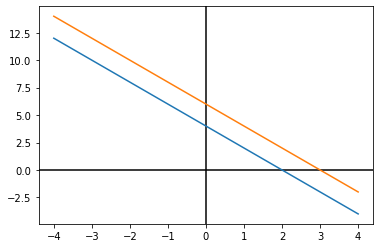

LinAlgError: Singular matrix

In [3]:
from my_plot import plot
import numpy as np

def f(x):
    return (8 - 4 * x) / 2

def g(x):
    return 6 - 2 * x

plot([f, g], -4, 4)

f = (4, 2, 8)
g = (2, 1, 6)

m = np.array(((4, 2), (2, 1)))
v = np.array((6, 4))
solution = np.linalg.solve(m, v)



The previous code throws an exception, because the system cannot find a solution vector $ (x, y) $ such that:

$
\begin{pmatrix}
2 & 1 \\
4 & 2
\end{pmatrix} \begin{pmatrix}
x \\
y
\end{pmatrix} = \begin{pmatrix}
6 \\
4
\end{pmatrix}
$

In fact, the matrix:

$
\begin{pmatrix}
2 & 1 \\
4 & 2
\end{pmatrix}
$

is called a *singular matrix*, meaning there is no unique solution to the linear system.

For the purpose of the game, we can just modify the `do_segments_intersect(...)` to catch the exception and return the result as `False`:

```python
def do_segments_intersect(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        return (
            distance(u1, (x, y)) <= d1 and
            distance(u2, (x, y)) <= d1 and
            distance(v1, (x, y)) <= d2 and
            distance(v2, (x, y)) <= d2
        )
    except np.linalg.linalg.LinAlgError:
        return False
```

Let's see now what happens when we pass the same line, for example:

$ 
4x + 2y = 8 $ and $ 2x + y = 4 
$

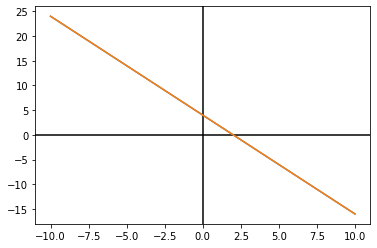

LinAlgError: Singular matrix

In [5]:
from my_plot import plot
import numpy as np

def f(x):
    return (8 - 4 * x) / 2

def g(x):
    return 4 - 2 * x

plot([f, g], -10, 10)

f = (4, 2, 8)
g = (2, 1, 4)

m = np.array(((4, 2), (2, 1)))
v = (8, 4)
solution = np.linalg.solve(m, v)


You can see that the matrix is the same, so we end up catching the same exception `np.linalg.linalg.LinAlgError` with the message `'Singular matrix'`.

## Generalizing linear equations to higher dimensions

Linear equations in the wild are sets of linear equations having more than two *unknown* variables. Such equations describe collections of points in more than 2D that satisfy the equations.

### Representing planes in 3D

Lines and planes are analogous in the 2D and 3D space respectively. For example, the equation:

$
ax + by = c
$

is the set of points $ (x, y) $ in the 2D plane where the dot product with a fixed vector $ (a, b) $ is the fixed number $ c $.

$
(a, b) \cdot (x, y) = a * x + b * y = c
$

Let's interpret this fact graphically.

If we have a point and a non-zero vector in 2D there is a unique line that is perpendicular to the vector and also passes through the point.

![Visual Interpretation of the Dot Product](../images/dot_product_visual_interpretation.png)

Let's call the point $ (x_0, y_0) $ and the given vector $ (a, b) $.

The points that lie on the line $ (x, y) $ are such that:
+ $ (x - x_0, y - y_0) $ is parallel to the line
+ $ (x - x_0, y - y_0) $ is perpendicular to $ (a, b) $

![Visual interpretation 2](../images/dot_product_visual_interpretation_2.png)

As we know that two perpendicular vectors have a zero dot product we can write:

$
(a, b) \cdot (x - x_0, y - y_0) = 0 \\
a (x - x_0) + b (y - y_0) = 0 \\
a x + by = a x_0 + b y_0
$

The quantity on the right hand side is constant, so we can rename it as c, which gives us a hany geometric interpretation of the formula $ ax + by = c $:

> Given a point in the 2D plane $ (x_0, y_0) $ and a non-zero vector $ (a, b) $, the equation $ ax + by = a x_0 + b y_0 $ gives us all the points determined by all the the vectors $ (x, y) $ that are perpendicular to $ (a, b) $.


A similar approach we can take for a vector in 3D.